# Étape 5 – Visualisation et Interprétation des Vulnérabilités

Ce notebook présente les visualisations demandées dans l'étape 5 du projet Mastercamp 2025.Il utilise un fichier CSV enrichi (`cve_ansi_enriched_save.csv`) pour analyser les vulnérabilités extraites depuis les flux ANSSI et enrichies via les API externes (MITRE, EPSS).


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Chargement du fichier enrichi
DATA_PATH = "../../cve_ansi_enriched_final.csv"
OUTPUT_DIR = Path("visualisations")
OUTPUT_DIR.mkdir(exist_ok=True)

# Chargement complet
df_all = pd.read_csv(DATA_PATH)

# Nettoyage pour certaines visualisations
df = df_all[(df_all['cvss'].notna()) & (df_all['cvss'] != "Non disponible")]
df = df[(df['epss'].notna()) & (df['epss'] != "Non disponible")]
df = df[~df['cwe'].str.contains("Non disponible", na=False)]

df['cvss'] = df['cvss'].astype(float)
df['epss'] = df['epss'].astype(float)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_all['date'] = pd.to_datetime(df_all['date'], errors='coerce')


## Prémières explorations du DataFrame après nettoyage des valeurs manquantes

In [41]:
df.shape

(7897, 16)

In [42]:
df.head()

,id,title,type,date,cve,cvss,base severity,cwe,epss,percentile,vector,lien,description,editeur,produit,versions
4,CERTFR-2021-ALE-004,[MàJ] Multiples vulnérabilités dans Microsoft ...,alerte,2021-07-16,CVE-2021-26858,7.8,HIGH,Remote Code Execution,0.15565,0.95902,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H/E...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2021-...,Microsoft Exchange Server Remote Code Executio...,Non disponible,Non disponible,[]
5,CERTFR-2021-ALE-004,[MàJ] Multiples vulnérabilités dans Microsoft ...,alerte,2021-07-16,CVE-2021-27078,9.1,CRITICAL,Remote Code Execution,0.02212,0.89154,CVSS:3.1/AV:N/AC:L/PR:H/UI:N/S:C/C:H/I:H/A:H/E...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2021-...,Microsoft Exchange Server Remote Code Executio...,Non disponible,Non disponible,[]
6,CERTFR-2021-ALE-004,[MàJ] Multiples vulnérabilités dans Microsoft ...,alerte,2021-07-16,CVE-2021-26857,7.8,HIGH,Remote Code Execution,0.61868,0.97986,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H/E...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2021-...,Microsoft Exchange Server Remote Code Executio...,Non disponible,Non disponible,[]
7,CERTFR-2021-ALE-004,[MàJ] Multiples vulnérabilités dans Microsoft ...,alerte,2021-07-16,CVE-2021-26855,9.1,CRITICAL,Remote Code Execution,0.97508,0.99992,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:N/E...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2021-...,Microsoft Exchange Server Remote Code Executio...,Non disponible,Non disponible,[]
8,CERTFR-2021-ALE-004,[MàJ] Multiples vulnérabilités dans Microsoft ...,alerte,2021-07-16,CVE-2021-27065,7.8,HIGH,Remote Code Execution,0.95775,0.99592,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H/E...,https://www.cert.ssi.gouv.fr/avis/CERTFR-2021-...,Microsoft Exchange Server Remote Code Executio...,Non disponible,Non disponible,[]


In [47]:
df.columns

Index(['id', 'title', 'type', 'date', 'cve', 'cvss', 'base severity', 'cwe',
       'epss', 'percentile', 'vector', 'lien', 'description', 'editeur',
       'produit', 'versions'],
      dtype='object')

In [46]:
df.dtypes

id                       object
title                    object
type                     object
date             datetime64[ns]
cve                      object
cvss                    float64
base severity            object
cwe                      object
epss                    float64
percentile               object
vector                   object
lien                     object
description              object
editeur                  object
produit                  object
versions                 object
dtype: object

In [44]:
df.nunique()

id               1193
title             367
type                2
date              456
cve              7897
cvss               83
base severity       5
cwe              1566
epss              776
percentile       3305
vector           1223
lien             1193
description      6603
editeur            96
produit           267
versions         1153
dtype: int64

In [48]:
df.describe(include='all')

,id,title,type,date,cve,cvss,base severity,cwe,epss,percentile,vector,lien,description,editeur,produit,versions
count,7897,7897,7897,7897,7897,7897.000000,7897,7897,7897.000000,7897,7897,7897,7897,7897,7897,7897
unique,1193,367,2,NaN,7897,NaN,5,1566,NaN,3305,1223,1193,6603,96,267,1153
top,CERTFR-2025-AVI-0258,Multiples vulnérabilités dans Microsoft Windows,avis,NaN,CVE-2021-26858,NaN,HIGH,CWE-122: Heap-based Buffer Overflow,NaN,0.112,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:N/A:H,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,Secure Boot Security Feature Bypass Vulnerability,Microsoft,Non disponible,[]
freq,147,1098,7809,NaN,1,NaN,3575,290,NaN,1447,344,147,47,1730,2650,201
mean,NaN,NaN,NaN,2024-08-21 20:41:25.399518720,NaN,6.794213,NaN,NaN,0.011009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,2021-05-12 00:00:00,NaN,0.000000,NaN,NaN,0.000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2024-04-11 00:00:00,NaN,5.500000,NaN,NaN,0.000430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2024-09-11 00:00:00,NaN,7.100000,NaN,NaN,0.000490,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,2025-01-23 00:00:00,NaN,7.800000,NaN,NaN,0.000830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,2025-06-18 00:00:00,NaN,10.000000,NaN,NaN,0.975080,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
(df_all == "Non disponible").mean() * 100  # Pourcentage de valeurs manquantes par colonne avant nettoyage

id                0.000000
title             0.000000
type              0.000000
date              0.000000
cve               0.000000
cvss             59.152618
base severity    59.152618
cwe              58.771074
epss             27.994676
percentile       27.994676
vector           59.152618
lien              0.000000
description      28.101154
editeur           4.773736
produit          42.302573
versions          0.000000
dtype: float64

## Histogramme des Scores CVSS

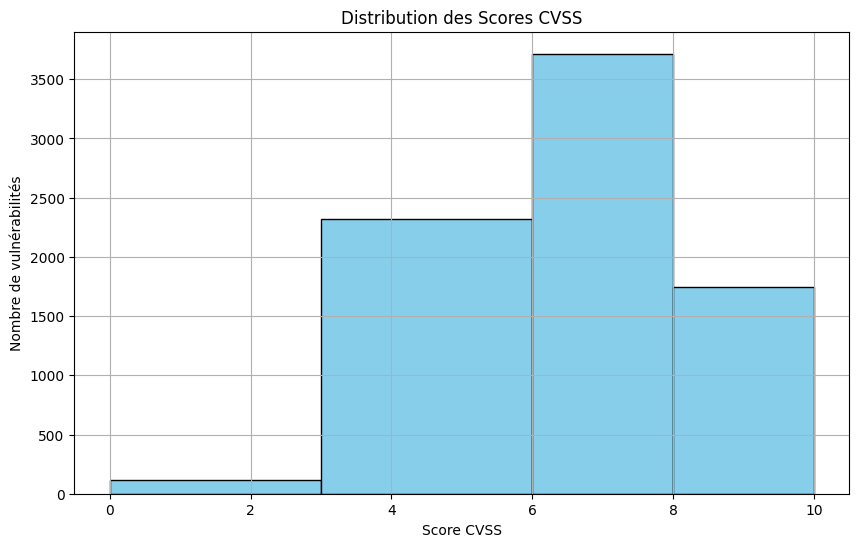

In [5]:
plt.figure(figsize=(10, 6))
df['cvss'].hist(bins=[0, 3, 6, 8, 10], edgecolor='black', color='skyblue')
plt.title("Distribution des Scores CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.show()

## Répartition des types CWE (Top 10)

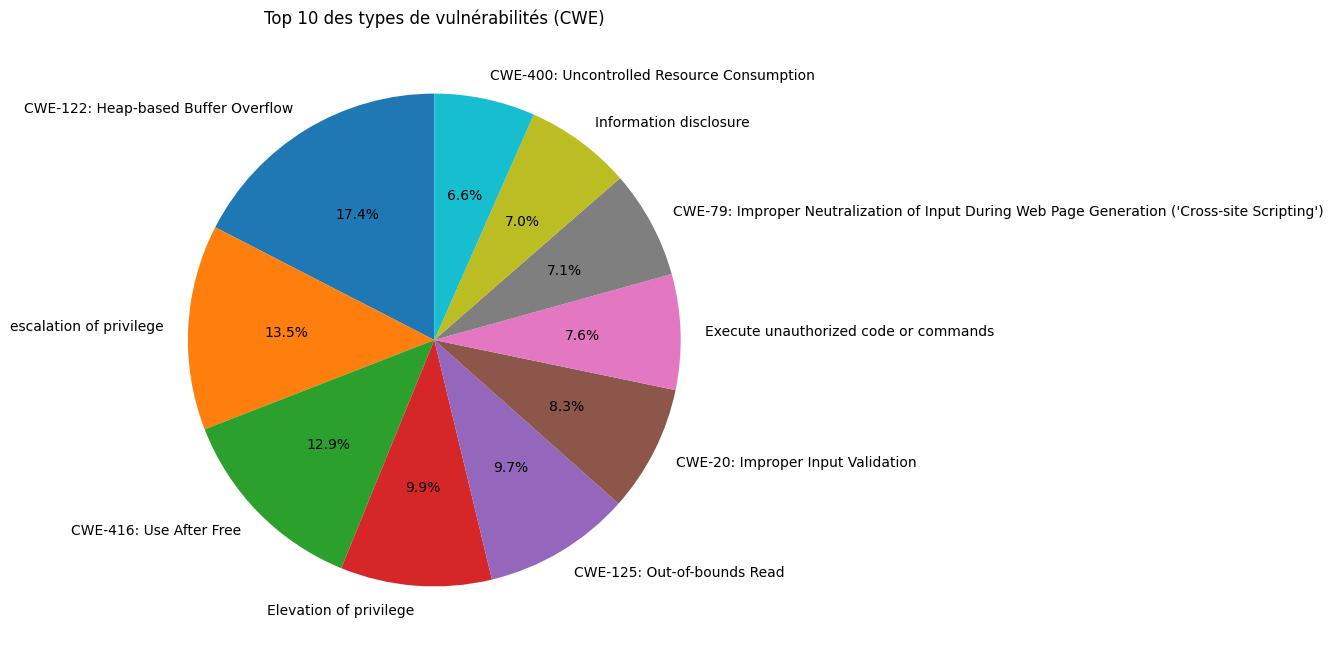

In [6]:
cwe_counts = df['cwe'].value_counts().head(10)
plt.figure(figsize=(8, 8))
cwe_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Top 10 des types de vulnérabilités (CWE)")
plt.ylabel("")
plt.show()

## Courbe des scores EPSS

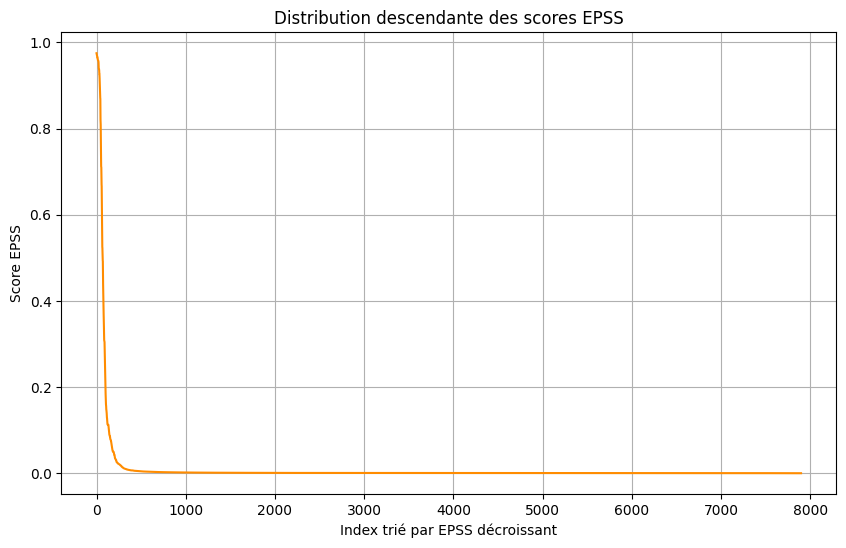

In [7]:
df_sorted = df.sort_values(by='epss', ascending=False).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(df_sorted.index, df_sorted['epss'], color='darkorange')
plt.title("Distribution descendante des scores EPSS")
plt.xlabel("Index trié par EPSS décroissant")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.show()

## Top 10 des éditeurs les plus cités

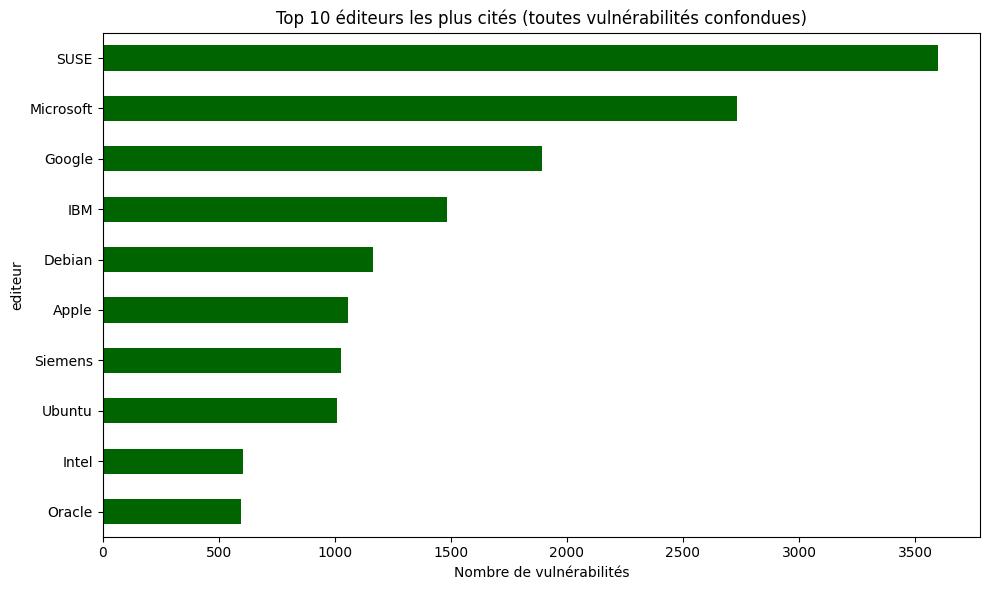

In [8]:
df_editors = df_all[df_all['editeur'].notna() & (df_all['editeur'] != "Non disponible")]
top_editors = df_editors['editeur'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_editors.plot(kind='barh', color='darkgreen')
plt.title("Top 10 éditeurs les plus cités (toutes vulnérabilités confondues)")
plt.xlabel("Nombre de vulnérabilités")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Corrélation CVSS vs EPSS

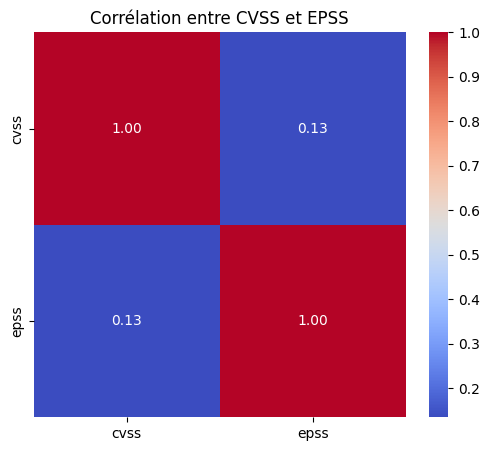

In [9]:
plt.figure(figsize=(6, 5))
sns.heatmap(df[['cvss', 'epss']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre CVSS et EPSS")
plt.show()

## Nuage de points : CVSS vs EPSS

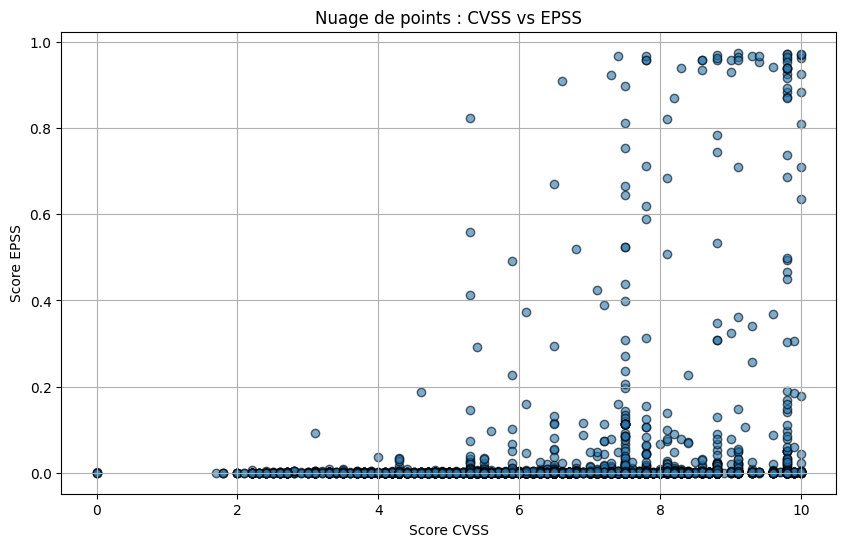

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df['cvss'], df['epss'], alpha=0.6, edgecolors='k')
plt.title("Nuage de points : CVSS vs EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.show()

## Évolution temporelle des vulnérabilités

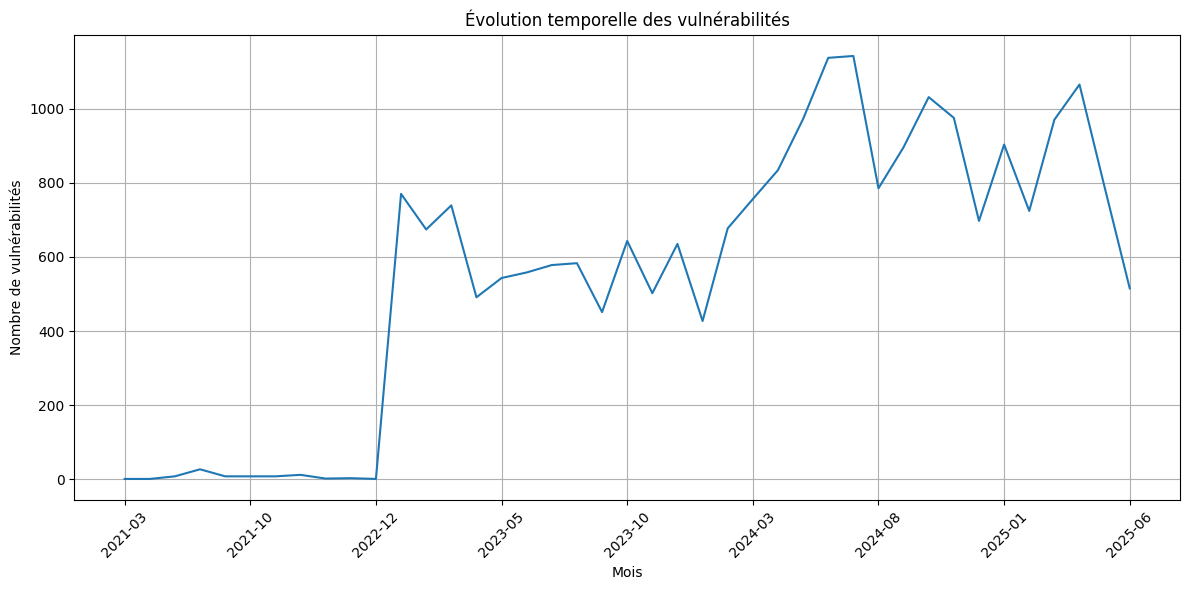

In [11]:
df_all['mois'] = df_all['date'].dt.to_period("M")
vulns_by_month = df_all.groupby('mois').size()
vulns_by_month.index = vulns_by_month.index.astype(str)
plt.figure(figsize=(12, 6))
vulns_by_month.plot()
plt.title("Évolution temporelle des vulnérabilités")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Boxplot des scores CVSS par éditeur (Top 5)

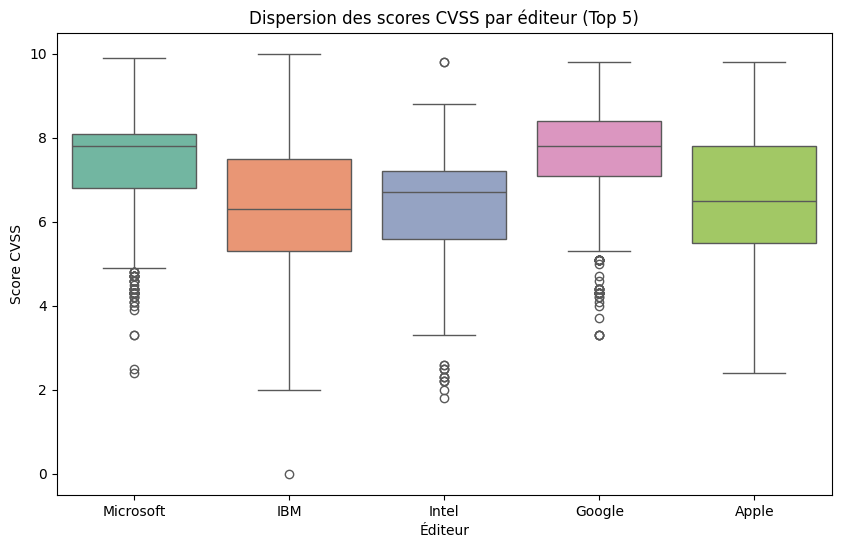

In [12]:
top5_editors = df['editeur'].value_counts().head(5).index
df_top5 = df[df['editeur'].isin(top5_editors)]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top5, x='editeur', y='cvss', hue='editeur', palette='Set2', legend=False)
plt.title("Dispersion des scores CVSS par éditeur (Top 5)")
plt.xlabel("Éditeur")
plt.ylabel("Score CVSS")
plt.show()

# Étape 7 – Machine Learning

## Étape 1: Machine learning unsupervised

Pour la partie unsupervised, nous allons proposer 2 modèles différents

## Premier modèle unsupervised:

Clustering Kmean sans label qui utilise les features suivantes : Epss, CVSS et base_severity.
Notre but ici en utilisant Kmean est de regrouper les données similaires ensemble et les découper en K groupes pour tenter d'observer l'apparition de groupe d'individues et dévoiler possiblement des structures cachées.

## On prépare d'abord les données pour le Kmean

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_csv("../../cve_ansi_enriched_final.csv")
df = df[df['cvss'].notna() & (df['cvss'] != "Non disponible")]
df = df[df['epss'].notna() & (df['epss'] != "Non disponible")]
df = df[df['base severity'].notna()]
df['cvss'] = df['cvss'].astype(float)
df['epss'] = df['epss'].astype(float)

severity_mapping = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2, 'CRITICAL': 3}
valid_severities = set(severity_mapping.keys())
df = df[df['base severity'].str.upper().isin(valid_severities)]
df['severity_encoded'] = df['base severity'].str.upper().map(severity_mapping)

# On définit les données qu'on va utilliser


features = ['cvss', 'epss','severity_encoded']
X = df[features]


## Comment choisir le k (nombre de clusters) ?


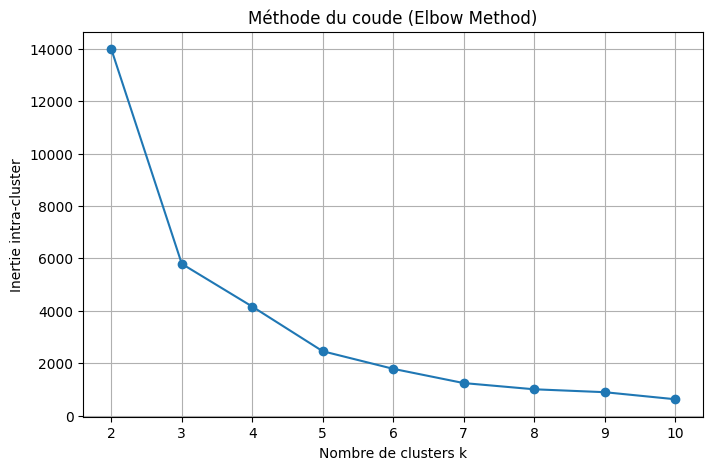

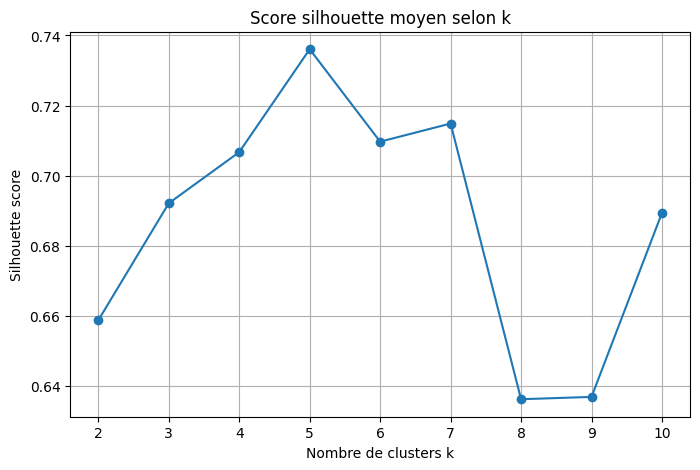

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertias = []
silhouettes = []

K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)  # fit + predict en une seule ligne
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Tracer les courbe
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.title("Méthode du coude (Elbow Method)")
plt.xlabel("Nombre de clusters k")
plt.ylabel("Inertie intra-cluster")
plt.xticks(K)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(K, silhouettes, marker='o')
plt.title("Score silhouette moyen selon k")
plt.xlabel("Nombre de clusters k")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

Une fois qu'on a notre bon k, dans notre cas k = 5 car c'est le compromis parfait entre le maximum du score silhouette et la cassure sur le graphe de la méthode du coude

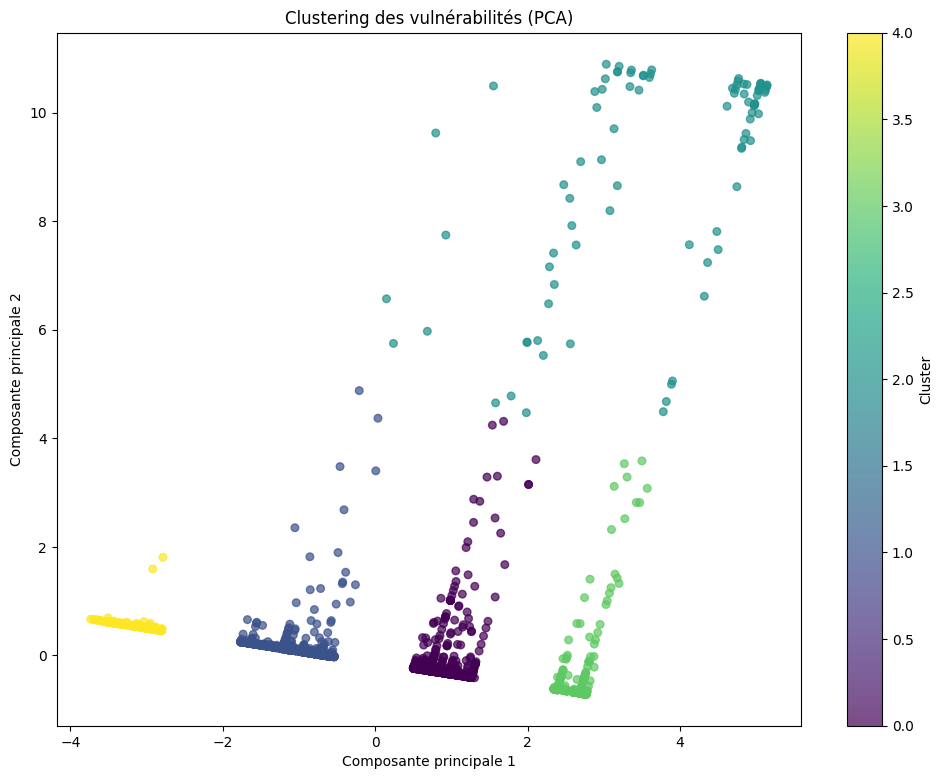

In [33]:
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)

# Ajout des labels au DataFrame
df['cluster'] = kmeans.labels_


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = df['cluster']  # ajouter les clusters


plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
    c=df['cluster'],
    cmap='viridis',
    s=30,         # taille réduite des points
    alpha=0.7 )    # transparence)
plt.title('Clustering des vulnérabilités (PCA)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()

Au final, ce modèle nous aura permis de voir qu'il y a clairement des groupe qui se forment dans notre population. Cela pourra possiblement être utile dans l'éfficacité de la recherche de solution pour un individu se trouvant dans un groupe déjà connue.

In [34]:
print(df['cluster'].value_counts())
print(df.groupby('cluster')[['cvss', 'epss', 'severity_encoded']].mean())

cluster
0    4173
1    3901
3     579
4     438
2      90
Name: count, dtype: int64
             cvss      epss  severity_encoded
cluster                                      
0        7.876827  0.003411          2.000000
1        5.639913  0.001716          1.000000
2        8.715556  0.818724          2.444444
3        9.601727  0.012153          3.000000
4        3.188813  0.001153          0.000000


## Deuxième modèle unsupervised:

Clustering Kmean sans label qui utilise la colonne cwe.
Notre but ici en utilisant Kmean est de regrouper automatiquement les descriptions de vulnérabilités similaires (CWE) en plusieurs catégories thématiques, sans étiquettes préexistantes, pour en faciliter l’analyse ou la classification ultérieure.

## Préparation des données

In [16]:
import re


df = pd.read_csv("../../cve_ansi_enriched_final.csv")
df = df[df['cvss'].notna() & (df['cvss'] != "Non disponible")]
df = df[df['epss'].notna() & (df['epss'] != "Non disponible")]
df = df[df['cwe'].notna() & (df['cwe'] != "Non disponible")]
df = df[df['base severity'].notna()]
df['cvss'] = df['cvss'].astype(float)
df['epss'] = df['epss'].astype(float)

severity_mapping = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2, 'CRITICAL': 3}
valid_severities = set(severity_mapping.keys())
df = df[df['base severity'].str.upper().isin(valid_severities)]
df['severity_encoded'] = df['base severity'].str.upper().map(severity_mapping)

def clean_cwe_text(cwe_entry):
    if pd.isna(cwe_entry):
        return None

    cleaned = re.sub(r'^CWE-\d+[:\s-]*', '', str(cwe_entry).strip())
    cleaned = re.sub(r'\(?CWE-\d+\)?', '', cleaned)
    cleaned = cleaned.lower()
    cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned)
    cleaned = ' '.join([word for word in cleaned.split() if len(word) > 2])

    return cleaned

df['cwe_cleaned'] = df['cwe'].apply(clean_cwe_text)



In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
# Initialisation du vectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.8,     # ignore les mots trop fréquents
    min_df=2,       # ignore les mots trop rares
    ngram_range=(1, 2)  # unigrams + bigrams
)

# Application du vectorizer sur la colonne cwe_cleaned
X_text = vectorizer.fit_transform(df['cwe_cleaned'].fillna(''))


terms = vectorizer.get_feature_names_out()
mean_tfidf = np.asarray(X_text.mean(axis=0)).flatten()
top_indices = mean_tfidf.argsort()[::-1][:15]

print("\nTop 15 termes par importance moyenne TF-IDF :")
for i in top_indices:
    print(f"{terms[i]} → {mean_tfidf[i]:.4f}")


Top 15 termes par importance moyenne TF-IDF :
improper → 0.0408
use → 0.0362
free → 0.0351
privilege → 0.0351
use free → 0.0344
buffer → 0.0296
overflow → 0.0267
escalation → 0.0249
escalation privilege → 0.0248
buffer overflow → 0.0235
outofbounds → 0.0226
input → 0.0217
access → 0.0215
information → 0.0198
heapbased → 0.0196


In [18]:
from sklearn.cluster import KMeans

k = 5# On choisit la valeur de thème qu'on veut
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_text)

df['cwe_cluster'] = labels

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

print("\nMots-clés dominants par cluster :")
for i in range(k):
    print(f"\nCluster {i} :")
    for ind in order_centroids[i, :10]:
        print(f"  {terms[ind]}")




Mots-clés dominants par cluster :

Cluster 0 :
  authorization
  uncontrolled resource
  resource consumption
  consumption
  uncontrolled
  resource
  missing authorization
  missing
  incorrect authorization
  incorrect

Cluster 1 :
  outofbounds
  outofbounds read
  read
  outofbounds write
  write
  read libtiff
  libtiff
  vulnerability
  networking
  memory

Cluster 2 :
  path
  path traversal
  traversal
  limitation pathname
  improper limitation
  limitation
  restricted directory
  pathname restricted
  pathname
  restricted

Cluster 3 :
  use
  free
  privilege
  use free
  buffer
  overflow
  escalation
  escalation privilege
  buffer overflow
  information

Cluster 4 :
  improper
  input
  input validation
  improper input
  validation
  control
  improper access
  access control
  improper neutralization
  neutralization


## Qu'est ce qu'on peut déduire de ces résultats ?

On peut déduire des thèmes pour chaque cluster par exemple:
Cluster 0 : On parle ici sûrement de Contrôle d’accès défaillant ,
Cluster 1 : Corruption mémoire , Cluster 2 : Failles de type Path Traversal , etc...

## Étape 2: Machine learning unsupervised

Pour la partie supervised, nous allons proposer 2 modèles différents

## Premier modèle supervised:

Dans ce premier modèle supervisé, on va mettre en place un arbre de décision, dans le but de prédire la sévérité d’une vulnérabilité à partir de son score CVSS. On cherche à modéliser  le lien entre les indicateur numérique (cvss et epss) et une étiquette qualitative (base severity). Le choix de l'algorithme DecisionTreeClassifier vient du fait que c'est un modèle qui est adapté pour des structures assez simple avec peu de dimension

## Préparation des données


In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../../cve_ansi_enriched_final.csv")
df = df[df['cvss'].notna() & (df['cvss'] != "Non disponible")]
df = df[df['epss'].notna() & (df['epss'] != "Non disponible")]
df = df[df['base severity'].notna() & (df['base severity'] != "Non disponible")]
df['cvss'] = df['cvss'].astype(float)
df['epss'] = df['epss'].astype(float)

severity_mapping = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2, 'CRITICAL': 3}
valid_severities = set(severity_mapping.keys())
df = df[df['base severity'].str.upper().isin(valid_severities)]
df['severity_encoded'] = df['base severity'].str.upper().map(severity_mapping)

features = ['cvss']
labels = ['severity_encoded']
X = df[features]
y = df[labels]

## Application de l'algorithme

=== Decision Tree ===
              precision    recall  f1-score   support

         LOW       1.00      1.00      1.00        83
      MEDIUM       1.00      1.00      1.00       772
        HIGH       1.00      1.00      1.00       859
    CRITICAL       1.00      1.00      1.00       123

    accuracy                           1.00      1837
   macro avg       1.00      1.00      1.00      1837
weighted avg       1.00      1.00      1.00      1837



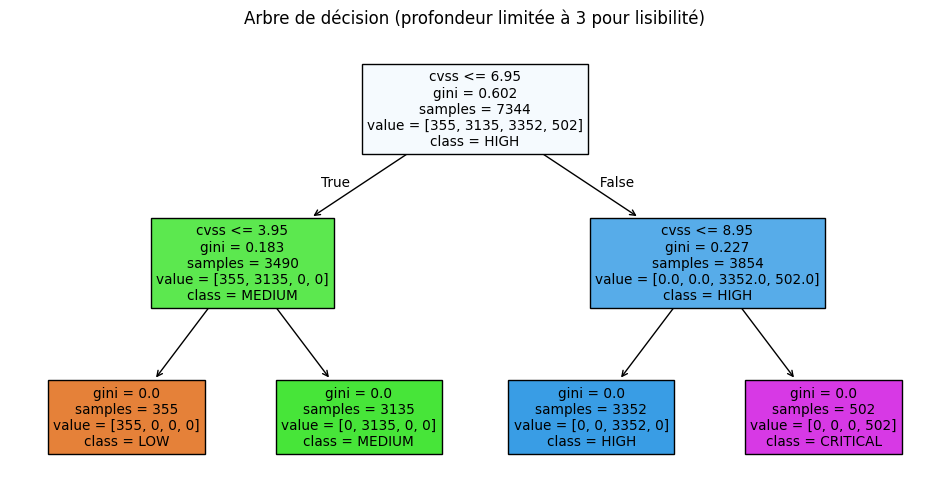

In [20]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Séparation des données en ensemble d'entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Prédiction
y_pred = dt.predict(X_test)

# Évaluation
print("=== Decision Tree ===")
print(classification_report(y_test, y_pred, target_names=severity_mapping.keys()))

# Affichage de l’arbre (simplifié pour visualisation)
plt.figure(figsize=(12, 6))
plot_tree(dt, feature_names=features, class_names=list(severity_mapping.keys()), filled=True, max_depth=3)
plt.title("Arbre de décision (profondeur limitée à 3 pour lisibilité)")
plt.show()

# Qu'est ce qu'on déduit de ce résultat ?

Dans notre cas, ce modèle se révèle être finalement pas très utile car par déduction on pouvait s'attendre à ce que la base severity soit directement et seulement déduis du score CVSS. Comme on peut le voir notre modèle à déduit avec une précision de 100 % les base severity seulement avec les scores cvss sans utiliser les score epss.

## Second modèle supervisé

Pour ce second model, on va tenter de prédire le score CVSS. On va essayer de mettre en œuvre un pipeline de régression supervisée en se basant sur deux types d’informations : la description textuelle de la faille et le type de vulnérabilité (CWE).

## Point important à comprendre

Le score cvss est un score qui est calculé directement à partir de la donnée vectorString qu'on retrouve à l'aide de l'API mitre. Un vectorString ressemble à ça : "CVSS:3.1/AV:N/AC:L/PR:H/UI:N/S:C/C:H/I:H/A:H/E:P/RL:O/RC:C". Nous avons tout de même décidé de faire un modèle qui prédit le CVSS en utilisant seulement des descriptions textuelles pour apporter une nouvelles approche de la définition des scores CVSS des CVE.


## Préparation des données

In [21]:
import pandas as pd
import re
from sklearn.preprocessing import OneHotEncoder

# Chargement du fichier CSV
df = pd.read_csv("../../cve_ansi_enriched_final.csv")

# Filtrage des lignes valides
df = df[df['cvss'].notna() & (df['cvss'] != "Non disponible")]
df = df[df['cwe'].notna() & (df['cwe'] != "Non disponible")]
df = df[df['description'].notna() & (df['description'] != "Non disponible")]

# Nettoyage du texte description
def clean_description_text(desc):
    if pd.isna(desc):
        return None
    cleaned = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(desc))
    cleaned = cleaned.lower()
    cleaned = ' '.join([word for word in cleaned.split() if len(word) > 2])
    return cleaned

df['description_cleaned'] = df['description'].apply(clean_description_text)

# Suppression des lignes vides après nettoyage
df = df[df['description_cleaned'].notna()]

# Extraction du code CWE (ex: "CWE-200") depuis la chaîne
df['cwe_code'] = df['cwe'].apply(lambda x: re.search(r'CWE-\d+', x).group(0) if re.search(r'CWE-\d+', x) else None)

# Création de la colonne CWE_cleaned (description sans le code CWE)
def clean_cwe_text(cwe):
    if pd.isna(cwe):
        return None
    # Supprimer tous les motifs "CWE-xxx" et nettoyer l'espace
    return re.sub(r'CWE-\d+\s*', '', cwe).strip()

df['CWE_cleaned'] = df['cwe'].apply(clean_cwe_text)

# Suppression des lignes dont le CWE_cleaned n’apparaît qu’une seule fois
cwe_counts = df['CWE_cleaned'].value_counts()
df = df[df['CWE_cleaned'].isin(cwe_counts[cwe_counts > 1].index)]

## Choix de l'algorithme : TF-IDF pour encoder la description et One-hot pour les description de CWE

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack

# Encodage TF-IDF de description_cleaned
tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_desc = tfidf_vectorizer.fit_transform(df['description_cleaned'])

# Encodage One-Hot de CWE_cleaned
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_cwe = encoder.fit_transform(df[['CWE_cleaned']])


# Fusion des features
X = hstack([X_desc, X_cwe])
y = df['cvss'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Évaluation
y_pred = model.predict(X_test)
print("MSE :", mean_squared_error(y_test, y_pred))
print("R²  :", r2_score(y_test, y_pred))

MSE : 1.9396395674611562
R²  : 0.30347958148911347


L’utilisation combinée du TF-IDF pour le texte et du one-hot pour les catégories permet de tirer parti à la fois des nuances lexicales et de la structure catégorielle du jeu de données. Le modèle choisi (régression linéaire) est simple et rapide à entraîner, ce qui en fait une bonne base d’exploration avant d’éventuellement tester des approches plus complexes car comme on a vue avec la précision calculé à la fin de ce model, le résultat est plutôt mauvais avec un score R² faible. On va donc essayer d'adopter une approche par RandomForestRegressor qui est possiblement plus efficace dans des base à plusieurs dimensions.

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack

# Fusion des features
X = hstack([X_desc, X_cwe])
y = df['cvss'].values

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entraînement du modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE :", mse)
print("R²  :", r2)

MSE : 1.5367152097768522
R²  : 0.4481688562134093


Dans cette approche, le score R² est plus encourageant bien que toujours assez faible. On va tenter alors une dernière amélioration.